In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
target = np.loadtxt('data_clean/ncicancer_bin_targets.txt')
target.shape

(2305, 59)

In [12]:
hf = np.loadtxt('data_clean/ncicancer_input_kernel.txt')
hf.shape

(2305, 2305)

# 1. Preprocessing et Formattage des données de sortie

> On the github page of the project, it is written: "We notice that the activity score is computed according -10*log(GI50). We still need binary value as the activity outcome for classification task. According to NCBI, a molecule is 'active' if the activity score is over(**=) 60 and 'inactive' otherwise."


In [17]:
y_label = target.copy()
#y_label[y_label < 60] = -1
#y_label[y_label >= 60] = 1

In [641]:
y_label.shape

(2305, 59)

In [643]:
G.nodes()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58]

In [18]:
Kx = hf

** Visulisation des données: Repartition de la bioactivité moléculaire **

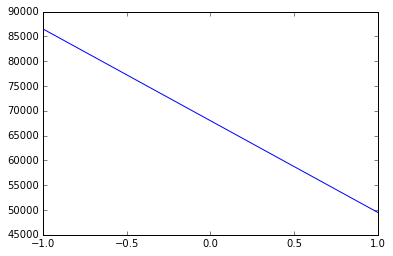

In [19]:
y_=np.empty(1)
for i in np.unique(target):
    y_ = np.append(y_,len(target[target == float(i)]))
y_= y_[1:]
plt.plot(np.unique(target), y_)

> On observe 3 pics de bioactivité modélculaire: 40, 60, 80. On en fait l'interprétation suivante (en accord avec les analyses de l'article):

> le pic à 40 peut être vu comme la mesure représentant une inactivité

> le pic à 80 peut être vu comme la mesure représentant une activité

> il y a des variations autour de ces données, avec une limite à 60. Cette limite est discutable. C'est celle utilisé dans l'article, mais on pourrait imaginer tester une autre limite d'activité.

** Justification de la limite à 60: Limite maximum pour que chaque molécule soit active sur un type de cellules, au moins**

In [21]:
np.min(np.max(target, axis=1))

1.0

# 2. Markov Network

The first step is to construct from the target data (cell-lines bioactivity) a correlation matrix between the pairs of cell lines. Then, we can extract the Markov network from the matrix by favoring high-valued pairs (two methods will be explained afterwards)

In [22]:
cov = np.cov(np.transpose(target)) # covariance matrix
pres = np.linalg.inv(cov) # precision matrix

### 2.1. Maximum weight spanning tree

In the paper, the maximum spanning tree is computed from additional data. Since we don't directly have access to this data, we tried first to build this tree by using the covariance matrix only (advise from Florence D'Alché Buc).

Using more additional data could be a way of improvement

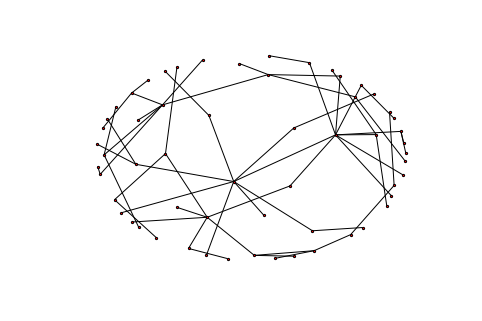

In [24]:
import networkx as nx
from spanning_tree import maximum_spanning_tree
A = cov.copy()
G = nx.from_numpy_matrix(A) # total graph
G = maximum_spanning_tree(G) # graph mst (minimum spanning tree)
nx.draw(G, node_size=5)

**Computing the tree on the normalized coviarance: **
This method doesn't give the same results. Indeed, since the delta between all the data are very small, changing the path doesn't change the total weight sum a lot. That is why we end up with a very different graph. We will keep the first one (without normalization).

**Understanding the Graph**

In [27]:
print(G.number_of_nodes())
print(G.order())
print(np.argsort(cov[0])[::-1])
test = np.argsort(cov[0])[::-1] [1]
print(G.has_edge(0,test))
print(G.edges()) #** Get edges for further analysis and use (mmCRF) **

59
59
[ 0 45 15 19 10 24 12  9 56 55 21 30 18  4 20  7 32 17 41  3 40 25 22 11 31
 54 13  1 53 58 33 26 34 38 27 23 28  2 29  5 42 14 16  6 52 37 35  8 36 46
 39 44 43 49 50 57 47 51 48]
True
[(0, 45), (0, 5), (1, 24), (1, 44), (2, 4), (3, 20), (3, 7), (4, 24), (6, 31), (7, 52), (8, 41), (9, 10), (9, 45), (10, 16), (10, 35), (10, 40), (10, 12), (10, 15), (11, 40), (12, 20), (12, 14), (13, 15), (15, 33), (17, 24), (17, 38), (17, 39), (18, 19), (19, 45), (20, 42), (21, 24), (21, 54), (22, 24), (23, 24), (24, 28), (24, 45), (25, 26), (25, 29), (25, 31), (27, 37), (27, 30), (30, 32), (30, 55), (30, 31), (31, 49), (31, 50), (31, 46), (33, 34), (36, 45), (41, 57), (41, 45), (43, 45), (45, 56), (45, 55), (47, 50), (48, 50), (49, 51), (53, 56), (56, 58)]


In [30]:
len(G.edges())*4

232

### 2.2. Correlation thresholding

Take all edges that exceed fixed threshold. This approach typically generates a general non-tree graph

In [25]:
threshold = 135
A_thresh = cov.copy()
A_thresh[cov < threshold] = 0

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

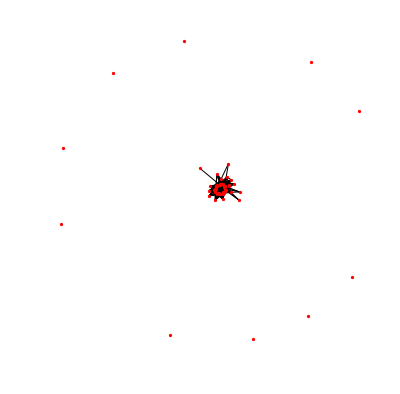

In [26]:
import networkx as nx
fig = plt.figure(figsize=(5,5))
G_thresh = nx.from_numpy_matrix(A_thresh)
rows, cols = np.where(A_thresh != 0)
edges = zip(rows.tolist(), cols.tolist())
G_thresh.add_edges_from(edges) 
nx.draw(G_thresh, node_size=5)

**Normalizing: ** Here, normalizing has a sense. Edges are determined by the thresholding, but when it is done we can normalize the weights. It will be the exact same edges, but normlized, which it better for vizualisation (see above). It makes sense to keep this method (with normalization).

/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/domitillecoulomb/anaconda3/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be

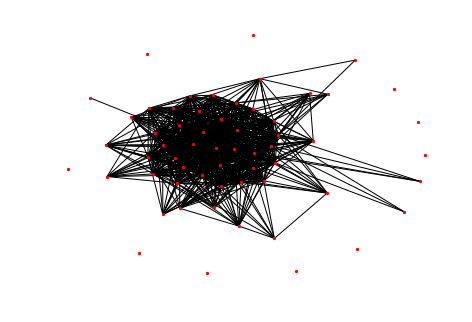

In [27]:
from sklearn import preprocessing
A_thresh = preprocessing.normalize(A_thresh)

G_thresh = nx.from_numpy_matrix(A_thresh)
rows, cols = np.where(A_thresh != 0)
edges = zip(rows.tolist(), cols.tolist())
G_thresh.add_edges_from(edges) 
nx.draw(G_thresh, node_size=5)

# 3. MMCRF

## 3.1 Theoritical problem

See paper **Efficient Algorithms for Max-Margin Structured Classification, Juho Rousu et al.**

Explains very well the optimization problem to be resolved in section 1.2.6 **Marginal dual problem**:

$$ \max_{\mu}\mu^{T} l_{H} − \frac{1}{2}\mu^{T}K_{H}\mu $$

Then the gradient becomes: 

$$ g = l_{H} − K_{H}\mu $$

Furthermore, the objective can be written as :  
$$obj = \mu^{T} l_{H} − \frac{1}{2}\mu^{T}K_{H}\mu$$
$$obj = \sum_{i=1}^{m}\sum_{e\in E}\sum_{u\in Y_{E}} \mu(e,u) l_{H}(i,u) − \frac{1}{2}\sum_{e\in E}\sum_{i,i^{'}}\sum_{u,u^{'}} \mu_{e}(i,u)K_{e}(i,u;i^{'},u^{'})\mu_{e}(i^{'},u^{'})$$

That's why we need to construct the full loss vector (for each of the 4 possible labels), and K_mu_X and K_mu for the gradient descent


## 3.2 Conditional Gradient Algorithm

### 3.2.1. Functions for the algorithm

**Loss Vector**

In [605]:
#Y_tr=y_label, G=G
def compute_loss_vector(E, Y_tr):
    """
    LOSS VECTOR
    Compute loss vector to be used in the conditional gradient optimization
    """
    
    print('Computing loss vector...')
    
    labels = [-1,1]
    m = Y_tr.shape[0]
    e = len(E)
    
    """Initialize loss of size (4, M*E):
        M: nb of melecules
        E: nb of edges to be predicted for each molecule
        4: nb of losses to be computed (for each of the four possible labeling we compute a different loss)"""
    loss = np.ones((4,m*e))
    
    E_tail = [elt[0] for elt in E]
    E_head = [elt[1] for elt in E]
    Te1 = Y_tr[:,E_tail] # the label of edge tail
    print("plop")
    Te2 = Y_tr[:,E_head] # the label of edge head
    
    """Scaling the loss : rescale to microlabels by dividing node loss among the adjacent edges"""
    NodeDegree = np.array(list(G.degree().values()))
    NodeDegree = np.repeat(np.expand_dims(NodeDegree, axis = 0), m, axis=0)
    # np.concatenate() ?
    
    u = 0
    for u_1 in labels:
        for u_2 in labels:
            loss[u,:] = np.concatenate(np.divide((Te1 != u_1), NodeDegree[:, E_head]) + np.divide((Te2 != u_2), NodeDegree[:, E_tail]))
            u += 1
    loss = np.resize(loss, (4*e,m)) # try transpose
    
    return loss

loss = compute_loss_vector(E, y_label)

loss.shape
    

Computing loss vector...
plop


(232, 2305)

In [606]:
def compute_duality_gap(E, Y_tr, loss, Kmu, mu, primal_ub):
    """
    DUALITY GAP
    """
    
    m = Y_tr.shape[0]
    e = len(E)
    
    loss = np.resize(loss, (4,e*m))
    Kmu = np.resize(Kmu, (4,e*m))
    mu = np.resize(mu, (4,e*m))
    
    gradient = loss - Kmu
    
    #gradient = np.resize(gradient, (4,e*m)) # inutile ?
    
    dgap = float('inf'); LBP_iter = 1; Gmax = -float('inf')
    
    while LBP_iter <= e:
        
        LBP_iter *= 2 # no of iterations = diameter of the graph
        Ymax, max_gradient = max_gradient_labeling(gradient, LBP_iter) # "max_gradient" not to confuse with G
        ' "max_gradient" of size (4*e,m) '
        Gmax = np.maximum(Gmax, max_gradient)
        ' C: SVM hyperparameter '
        duality_gap = C*np.maximum(Gmax,0) - np.sum(np.resize(np.sum(gradient*mu, 0), (e,m)), 0)
        dgap = np.sum(duality_gap)
        
        if obj+dgap < primal_ub+1e-6:
            break
            
    # primal_ub = min(obj+dgap,primal_ub);
    
    if primal_ub == float('inf'): # initial value
         primal_ub = obj+dgap;
    else:
         primal_ub = (obj+dgap)/min(opt_round,10) + primal_ub*(1-1/min(opt_round,10)); # averaging over a few last rounds

    #loss = np.reisze(loss, (4*e,m))
    #Kmu = np.reisze(Kmu, (4*e,m))
    #mu = np.reisze(mu, (4*e,m))
    
    return dgap, primal_ub

In [649]:
def Y2U(E, Y_tr):
    """
    CONVERT NODE LABELING TO EDGE LABELING
    """

    m = Y_tr.shape[0]
    e = len(E)

    U = np.zeros((4,e*m))
    
    E_tail = [elt[0] for elt in E]
    E_head = [elt[1] for elt in E]
    Te1 = Y_tr[:,E_tail] # the label of edge tail
    Te2 = Y_tr[:,E_head] # the label of edge head

    U[0,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1), (1,e*m))
    U[1,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1), (1,e*m))
    U[2,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1), (1,e*m))
    U[3,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1), (1,e*m))
    
    return U

In [650]:
def max_gradient_labeling_brute_force(E, Y_tr, gradient):
    """
    Brute force inference of max. gradient labeling
    """

    m, l = Y_tr.shape
    e = len(E)

    Yall = np.zeros((2.**l,l))
    
    for j in range(l):
        
        tmp = np.concatenate((-np.ones((2**j,1)),np.ones((2**j,1))))
        Yall[:,j] = np.concatenate(np.repeat(np.expand_dims(tmp, 0), 2**(l-(j+1)), 0))[:,0]


    Yall = np.fliplr(Yall)

    Uall = np.resize(Y2U(Yall), (4*e,2**l))
    gradient = np.resize(gradient, (4*e,m))

    tmp = gradient.T.dot(Uall)
    
    Gmax = np.amax(tmp, 0) # ??
    Imax = np.argmax(tmp, 0) # ??
    Ymax = Yall[Imax,:] # np.unique ??
                  
    return Ymax, Gmax

In [651]:
class params():
    
    def __init__(self):
        self.a = 1
        self.b = 2

In [652]:
if 'z' in locals():
    print("plop")
else:
    print("plip")

plip


In [719]:
def max_gradient_labeling(E, n_nodes, Y_tr, gradient, MBProp, MBPropEdgeNode, params):
    """
    MAX GRAD. LABELING VIA LOOPY BELIEF PROPAGATION
    Find maximum gradient labeling for a single example using Loopy Belief Propagation
    
    gradient is of size (4*e,m) and contains the gradient (m-vector) for each edge-labeling (4*e in total)
    MBProp (2*e,2*e) direction-specific adjacency matrix
    """
    
    m, l = Y_tr.shape
    e = len(E)
    
    if params.debugging==1:
        Ymax, Gmax = max_gradient_labeling_brute_force(E, Y_tr, gradient)
    else:

        ineg = 1; ipos = 2;

        if np.all(MBProp==np.zeros((2*e, 2*e))): # MBProp is set to its initial values
            MBProp, MBPropEdgeNode = buildBeliefPropagationMatrix(E, n_nodes) # TO-DO

        gradient = np.resize(gradient, (4,e*m))

        ' Edge-labeling specific gradient matrices (m,e) '
        Gnn = np.resize(gradient[0,:], (e,m)).T # edge-gradients for labeling [-1,-1]
        Gnp = np.resize(gradient[1,:], (e,m)).T # edge-gradients for labeling [-1,+1]
        Gpn = np.resize(gradient[2,:], (e,m)).T # edge-gradients for labeling [+1,-1]
        Gpp = np.resize(gradient[3,:], (e,m)).T # edge-gradients for labeling [+1,+1]

        ' SumMsg_*_*: mx|E| matrices storing the sums of neighboring messages from '
        ' the head and tail of the edge, respectively, on the condition that '
        ' the head (resp. tail) is labeled with -1 --> neg or +1 --> pos. '
        SumMsg_head_neg = np.zeros((m,e))
        SumMsg_head_pos = np.zeros((m,e))
        SumMsg_tail_neg = np.zeros((m,e))
        SumMsg_tail_pos = np.zeros((m,e))

        iTail = np.arange(e)
        iHead = np.arange(e,2*e)

        ' Iterate until messages have had time to go accros the whole graph: at '
        ' most this takes O(e) iterations (i.e. when the graph is a chain) '
        for it in range(params.max_iter):
            ' find max-gradient configuration and propage gradient value over the edge '
            Msg_head_neg = np.maximum(SumMsg_tail_pos+Gpn, SumMsg_tail_neg+Gnn)
            Msg_head_pos = np.maximum(SumMsg_tail_pos+Gpp, SumMsg_tail_neg+Gnp)
            Msg_tail_neg = np.maximum(SumMsg_head_pos+Gnp, SumMsg_head_neg+Gnn)
            Msg_tail_pos = np.maximum(SumMsg_head_pos+Gpp, SumMsg_head_neg+Gpn)

            ' Sum up gradients of consistent configurations and propage to neighboring edges '
            SumMsg_tail_neg = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(MBProp[:,iTail])
            SumMsg_tail_pos = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(MBProp[:,iTail])
            SumMsg_head_neg = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(MBProp[:,iHead])
            SumMsg_head_pos = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(MBProp[:,iHead])


        ' find out the labeling: sum up the edge messages coming towards each node '
        M_max1 = np.hstack((Msg_tail_neg, Msg_head_neg)).dot(MBPropEdgeNode)
        M_max2 = np.hstack((Msg_tail_pos, Msg_head_pos)).dot(MBPropEdgeNode)
        ' pick the label of maximum message value '
        Ymax = (M_max1 <= M_max2)*2 - 1

        
        ' find out the max gradient for each example: pick out the edge labelings consistent with Ymax '        
        E_tail = [elt[0] for elt in E]
        E_head = [elt[1] for elt in E]
        
        Te1 = Ymax[:,E_tail] # the label of edge tail
        Te2 = Ymax[:,E_head]
                
        Umax = np.zeros((4, e*m))
                
        Umax[0,:] = np.resize(np.logical_and(Te1 == -1, Te2 == -1).T, (1,e*m))
        Umax[1,:] = np.resize(np.logical_and(Te1 == -1, Te2 == 1).T, (1,e*m))
        Umax[2,:] = np.resize(np.logical_and(Te1 == 1, Te2 == -1).T, (1,e*m))
        Umax[3,:] = np.resize(np.logical_and(Te1 == 1, Te2 == 1).T, (1,e*m))
        ' sum up the corresponding edge-gradients '
        Gmax = np.resize(np.sum(gradient*Umax, 0), (e,m))
        Gmax = np.resize(np.sum(Gmax, 0), (m,1))

        gradient = np.resize(gradient, (4*e,m))
                                
    return Ymax, Gmax

In [680]:
def buildBeliefPropagationMatrix(E, n_nodes):
    """
    Construct a matrix containing the neighborhood information of the edges.
    The matrix consists of four blocks, corresponding to the edges that merge 
    (e(2) = e'(2)), branch (e(1) = e'(1)), form a chain forward (e(2) = e'(1)) or backward (e(1) = e'(2))
    """
    
    e = len(E)
    
    E_tail = [elt[0] for elt in E]
    E_head = [elt[1] for elt in E]

    MBProp = np.zeros((2*e, 2*e)) # for edge to edge propagation
    MBPropEdgeNode = np.zeros((2*e, n_nodes)) # for edge to node propagation

    iTail = np.arange(e)
    iHead = np.arange(e,2*e)

    for node in range(n_nodes):
        eTail = np.where(np.asarray(E_tail) == node)[0]
        eHead = np.where(np.asarray(E_head) == node)[0]

        ' Edges that meet node with their tail '
        MBPropEdgeNode[iTail[eTail], node] = 1;
        ' Edges that meet node with the head '
        MBPropEdgeNode[iHead[eHead], node] = 1;

        ' Matrix block for progating messages from edges that meet with their tails at node (eTail) '
        Link = MBProp[np.ix_(iTail,iTail)]
        Link[np.ix_(eTail,eTail)] = 1
        ' remove diagonal; we do not propage messages back to self '
        MBProp[np.ix_(iTail, iTail)] = Link - np.diag(np.diag(Link)) # check

        ' Matrix block for progating messages via a backward chain (eTail meeting eHead) at node '
        ' messages will go from iTail to iTail (excluding self loops) '
        Link = MBProp[np.ix_(iTail, iHead)]
        Link[np.ix_(eTail, eHead)] = 1
        ' remove diagonal; in case there are self loops e = (v,v) in the graph '
        MBProp[np.ix_(iTail, iHead)] = Link - np.diag(np.diag(Link))

        ' Matrix block for progating messages from edges that meet with their heads at node (eHead) '
        Link = MBProp[np.ix_(iHead, iHead)]
        Link[np.ix_(eHead, eHead)] = 1 
        ' remove diagonal; we do not propage messages back to self '
        MBProp[np.ix_(iHead, iHead)] = Link - np.diag(np.diag(Link))

        ' Matrix block for progating messages  via a forward chain (eHead meeting eTail) at node; '
        Link = MBProp[np.ix_(iHead, iTail)]
        Link[np.ix_(eHead, eTail)] = 1
        ' remove diagonal; in case there are self loops e = (v,v) in the graph '
        MBProp[np.ix_(iHead, iTail)] = Link - np.diag(np.diag(Link))

    return MBProp, MBPropEdgeNode

In [681]:
def compute_w_phi_e(E, Ye, mu, Kx):
    
    e = len(E)
    
    m = Ye.shape[1]
    Ye = np.resize(Ye, (4,e*m))
    mu = np.resize(mu, (4,e*m))
    m_oup = Kx.shape[1]

    if (np.where(mu==1)[0].size)==0: # no match
        w_phi_e = np.zeros((4, e*m_oup))
    else  :
        w_phi_e = np.sum(mu, 0)
        w_phi_e = np.repeat(np.expand_dims(np.sum(w_phi_e, 0), 0), 4, 0)
        w_phi_e = Ye*w_phi_e
        w_phi_e = w_phi_e - mu
        w_phi_e = np.resize(w_phi_e, (4*e,m))
        w_phi_e = w_phi_e*Kx
        w_phi_e = np.resize(w_phi_e, (4,e*m_oup))

    return w_phi_e

In [682]:
def compute_error(E, Y_tr, Kx, mu, Ye, gradient, MBProp, MBPropEdgeNode, max_iter, params):
    """
    MODEL ERROR COMPUTATION
    """

    w_phi_e = compute_w_phi_e(E, Ye, mu, Kx)
    Ypred, _ = max_gradient_labeling(E, Y_tr, gradient, MBProp, MBPropEdgeNode, max_iter, params)
    
    return Ypred

In [784]:
def invert(X):
    return [not x for x in X]

In [1015]:
def optimize_x(E, n_nodes, Y_tr, MBProp, MBPropEdgeNode, Rmu, Smu, IndEdgeVal, x, obj, mu_x, Kmu_x, kxx_mu_x, loss_x, te_x, params):
    """
    Conditional gradient optimizer for a single example
    """

    it = 0
    while it < params.max_iter:

        gradient = loss_x - Kmu_x[:,0] 
        if np.linalg.norm(gradient) < params.tolerance:
            break
    
        ' find maximum gradient labeling (worst margin violator) '
        Ymax, Gmax = max_gradient_labeling(E, n_nodes, Y_tr, gradient, MBProp, MBPropEdgeNode, params)

        ' gradient towards zero '
        G0 = -mu_x.T.dot(gradient)
        
        ' convert to update direction '
        E_tail = [elt[0] for elt in E]
        E_head = [elt[1] for elt in E]
        Umax_e = 1 + 2*(Ymax[:,E_tail]>0) + (Ymax[:,E_head] >0)

        mu_1 = np.zeros(mu_x.shape)
        if np.all(Gmax > np.maximum(params.tolerance, G0)): # CHECK
        
            for u in range(4):
                mu_1[4*(np.arange(e))-4 + u] = params.C*(Umax_e == u)
          

            if np.sum(mu_1) > 0:
                smu_1_te = np.sum(np.resize(mu_1*te_x, (4,e)), 0)
                tmp = np.repeat(np.expand_dims(smu_1_te, 0), 4, 0)
                smu_1_te = np.resize(tmp, (mu_x.shape[0],1))
                kxx_mu_1 = np.asarray(invert(te_x))*params.C + mu_1 - smu_1_te[:,0]
                
                # kxx_mu_1 = ones(size(te_x))*C-te_x*C-smu_1_te+mu_1;
            else:
                kxx_mu_1 = np.zeros(mu_x.shape)

            Kmu_1 = Kmu_x[:,0] + kxx_mu_1 - kxx_mu_x;

        else:
            if np.all(G0 < params.tolerance): # CHECK
                break
            else:
                kxx_mu_1 = np.zeros(mu_x.shape)
                mu_1 = np.zeros(mu_x.shape)
                Kmu_1 = Kmu_x[:,0] + kxx_mu_1 - kxx_mu_x

        d_x = mu_1 - mu_x

        Kd_x = Kmu_1 - Kmu_x[:,0]
        l = gradient.T.dot(d_x)
        q = d_x.T.dot(Kd_x)
        alpha = min(l/q,1)

        delta_obj = gradient.T.dot(d_x)*alpha - alpha**2/2*d_x.T.dot(Kd_x) # CHECK

        if np.logical_or(delta_obj <= 0, alpha <= 0):
            break

        mu_x = mu_x + d_x*alpha
        Kmu_x = Kmu_x + Kd_x*alpha
        obj = obj + delta_obj
        kxx_mu_x = (1-alpha)*kxx_mu_x + alpha*kxx_mu_1

        it = it + 1
        
    """
    For speeding up gradient computations: 
    store sums of marginal dual variables, distributed by the true edge values into Smu
    store marginal dual variables, distributed by the pseudo edge values into Rmu
    """
    for u in range(4):
        Smu[u][:,x] = np.sum(mu_x).T*IndEdgeVal[u][:,x]
        Rmu[u][:,x] = mu_x[u,:].T

    mu_x = np.resize(mu_x, (4*e,1))
    
    return mu_x, kxx_mu_x, obj, it, Rmu, Smu

In [1016]:
a[0,:].shape, np.ndarray(a[0,:])

((4,), array([[[[ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.]]]]))

**Gradient Computation**

**K_mu_x**

In [1017]:
#mu_x = mu[:,x]

def compute_Kmu_x(x, Kx, E, IndEdgeVal, Smu, Rmu):
    """
    GRADIENT COMPUTATIONS
    Gradient for x
    """
    
    m = Kx.shape[0]
    e = len(E)
    
    """
    For speeding up gradient computations:
    Smu : store sums of marginal dual variables, distributed by the true edge values
    Rmu : store marginal dual variables, distributed by the pseudo edge values
    ... ???
    """
    
    #mu_x = np.resize(mu_x,(4,e));
    
    #for u in range(4):
    #    Smu[u][:,x] = np.sum(mu_x, axis=0) # sum margin variables over the 4 labeling losses
    #    Rmu[u][:,x] = mu_x[u,:] # take only the loss associated to the specific label tested
    #
    
    term12 = np.zeros((1, e))
    term34 = np.zeros((4, e)) #Kx.shape[1]))
    
    if Rmu == []:
        for u in range(4):
            Smu.append(np.zeros((e,m)))
            Rmu.append(np.zeros((e,m)))
    
    for u in range(4):
        Ind_te_u = IndEdgeVal[u][:,x] # loss of edges for this label, associated to the moledule x (boolean)
        H_u = Smu[u].dot(Kx)- Rmu[u].dot(Kx)
    
        term12[0,Ind_te_u] = H_u[Ind_te_u].T
        term34[u,:] = - H_u.T
    
    term12 = np.repeat(np.expand_dims(term12,axis=0), 4, axis=0)
    
    Kmu_x = np.resize(term12 + term34, (4*e,1))
    return Kmu_x



**K_mu**

In [1018]:
def compute_Kmu(Kx, E, IndEdgeVal, Smu, Rmu, mu0):
    """
    Complete gradient
    """

    m, m_oup = Kx.shape

    if 0: # and(params.debugging, nargin == 2) ????
    
        for x in range(m):
            Kmu[:,x] = compute_Kmu_x(x, Kx[:,x], E, IndEdgeVal, Smu, Rmu)

        Kmu = np.resize(Kmu, (4,e*m))
    else:

        mu0 = np.resize(mu0, (4,e*m))
        Smu = np.resize(np.sum(mu0, 0),(e,m))
        term12 = np.zeros((1,e*m_oup))
        Kmu = np.zeros((4,e*m_oup))

        for u in range(4):
            IndEVu = IndEdgeVal[u]
            Rmu_u = np.resize(mu0[u,:], (e,m))
            H_u = Smu*IndEVu
            H_u = H_u - Rmu_u
            Q_u = H_u.dot(Kx) # CHECK

            term12 = term12 + np.resize(Q_u*IndEVu, (1,e*m_oup))
            Kmu[u,:] = np.resize(-Q_u, (1,e*m_oup))

        for u in range(4):
            Kmu[u,:] = Kmu[u,:] + term12
    
    return Kmu

In [1019]:
import time

class profile():
    """
    EXECUTION PROFILING
    """
    
    def __init__(self):
        self.start_time = time.time()
        self.next_profile_tm = self.start_time
        self.n_err = 0
        self.p_err = 0
        self.n_err_microlbl = 0
        self.p_err_microlbl = 0 
        self.n_err_microlbl_prev = 0
        self.microlabel_errors = []
        self.it = 0
        self.err_ts = 0
        
    def profile_update(self, Ye, obj, mu, primal_ub, params):
        
        m = Ye.shape[1]
        tm = time.time()

        print('alg: M3LBP tm: %d  iter: %d obj: %s mu: max %s min %s dgap: %s'
        %(np.round(tm-self.start_time), self.it, obj, np.max(mu), np.min(mu), primal_ub-obj))
        
        ### COMPLETE WHEN RUNNING TO DISPLAY MORE INFORMATION


In [1020]:
class params():
    
    def __init__(self, C, epsilon, tolerance, max_iter, max_CGD_iter, max_LBP_iter, profiling, profile_tm_interval, verbosity, debugging):
        self.C = C
        self.epsilon = epsilon
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.max_CGD_iter = max_CGD_iter
        self.max_LBP_iter = max_LBP_iter
        self.profiling = profiling
        self.profile_tm_interval = profile_tm_interval
        self.verbosity = verbosity
        self.debugging = debugging

In [1021]:
parameters = params(C = 100,
                    epsilon = 1e-6,
                    tolerance = 1e-6,
                    max_iter = 10,
                    max_CGD_iter = 10,
                    max_LBP_iter = 10,
                    profiling = True,
                    profile_tm_interval = True,
                    verbosity = True,
                    debugging = False)

In [1022]:
def learn_MMCRF(Kx_tr, Y_tr, G, params):

    """
    Input data assumed by the algorithm
    
    Kx_tr        X-kernel, assume to be positive semidefinite and normalized (Kx_tr(i,i) = 1)
    Y_tr         Y-data: assumed to be class labels encoded {-1,+1}
    G            graph of the Markov network e_i = [E(i,1),E(i,2)]
    
    params       parameters used by the learning algorithm

    loss         losses associated with different edge labelings
    mu           marginal dual variables: these are the parameters to be learned

    m            number of training instances
    l            number of labels
    Ye           Denotes the edge-labelings 1 <-- [-1,-1], 2 <-- [-1,+1], 3 <-- [+1,-1], 4 <-- [+1,+1]
    IndEdgeVal   IndEdgeVal{u} = [Ye == u] 
    Kmu          Kx_tr*mu

    primal_ub
    profile
    obj
    params
    opt_round
    """
    
    """
    E            edges of the Markov network e_i = [E(i,1),E(i,2)]
    """
    E = G.edges() 
    e = len(E)
 
    #optimizer_init()
    vprofile = profile()

    l = Y_tr.shape[1]
    m = Kx_tr.shape[0]
    mu = np.zeros((4*e,m))
    loss = compute_loss_vector(E, Y_tr) # automatic scaling

    ' Matrices for speeding up gradient computations '
    Ye = np.resize(loss == 0, (4,e*m))
    
    IndEdgeVal = []
    for u in range(4):
        IndEdgeVal.append(np.resize(Ye[u,:]!=0, (e,m)))

    ' Initialization of variables '
    MBProp = np.zeros((2*e, 2*e)) # for edge to edge propagation
    MBPropEdgeNode = np.zeros((2*e, l)) # for edge to node propagation
    Rmu = []
    Smu = []

    Ye = np.resize(Ye, (4*e,m))
    Kxx_mu_x = np.zeros((4*e,m))
    Kmu = np.zeros((4*e*m,1)) # ??? good shape ?

    print('Starting descent...');
    obj = 0; primal_ub = float('inf'); it = 0; opt_round = 1;
    vprofile.profile_update(Ye, obj, mu, primal_ub, params)
    prev_obj = 0

    ' repeat until working set converged and close to optima '
    while (primal_ub - obj > params.epsilon*obj): #, vprofile.n_err_microlbl != vprofile.n_err_microlbl_prev):
  
        progress_made = 0
        print('Conditional gradient optimization...')
        for x in range(m):
            ' obtain initial gradient for x : Kmu_x '
            Kmu_x = compute_Kmu_x(x, Kx_tr[:,x], E, IndEdgeVal, Smu, Rmu)  

            ' conditional gradient optimization on x '
            mu_x[:,k], Kxx_mu_x[:,x], obj, x_iter, Rmu, Smu = \
            optimize_x(E, l, Y_tr, MBProp, MBPropEdgeNode, Rmu, Smu, IndEdgeVal, x, obj, mu[:,x], Kmu_x, Kxx_mu_x[:,x], loss[:,x], Ye[:,x], parameters)

            it = it + x_iter
            vprofile.it = it; 

            if parameters.verbosity:
                vprofile.profile_update(Ye, obj, mu, primal_ub, params)

                
        print('Current full gradient...')
        Kmu = compute_Kmu(Kx_tr, E, IndEdgeVal, Smu, Rmu, mu) # mu0=mu ???
        
        progress_made = (obj > prev_obj)
        if progress_made:
            prev_obj = obj
            prev_mu = mu
        else: # restore previous solution and finish
            mu = prev_mu
            Kmu = compute_Kmu(Kx_tr, E, IndEdgeVal, Smu, Rmu, mu)
            obj = mu.T.dot(loss) - mu.T.dot(Kmu)/2 

        print('Duality gap and primal upper bound')
        dgap, primal_ub = compute_duality_gap(E, Y_tr, loss, Kmu, mu, primal_ub)

        vprofile.profile_update(Ye, obj, mu, primal_ub, params)

        opt_round = opt_round + 1;
        if np.logical_or(opt_round > params.maxiter, progress_made == 0):
            vprofile.next_profile_tm = 0
            vprofile_update()
            break

    return mu

In [1023]:
learn_MMCRF(Kx, y_label, G, parameters)

Computing loss vector...
plop
Starting descent...
alg: M3LBP tm: 0  iter: 0 obj: 0 mu: max 0.0 min 0.0 dgap: inf
Conditional gradient optimization...


C:\Users\Paul\Anaconda4\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


(232,) (232,) (232,)
2534.72222222 610000.0
(232,) (232,) (232,)
2524.18973576 604941.088042
(232,) (232,) (232,)
2513.65724929 599903.241057
(232,) (232,) (232,)
2503.12476283 594886.459045
(232,) (232,) (232,)
2492.59227636 589890.742006
(232,) (232,) (232,)
2482.0597899 584916.089939
(232,) (232,) (232,)
2471.52730343 579962.502846
(232,) (232,) (232,)
2460.99481697 575029.980726
(232,) (232,) (232,)
2450.4623305 570118.523578
(232,) (232,) (232,)
2439.92984403 565228.131404


IndexError: too many indices for array

In [ ]:
(a==2)*100

In [ ]:
a = np.array([[1,2,3]])
b = np.array([[7,8,9],[10,11,12]])

a[[0 for i in range(4)],:]

### 3.2.2. Global variables and algorithm

In [16]:
E = G.edges()
l = y_label.shape[1]
m = Kx.shape[0]
mu = np.zeros((4*len(E),m))

Computing loss vector...


In [85]:
"""For speeding up gradient computations: j'ai pas trop réussi bein à comprendre le rôle de ces variables..."""
Smu = {}
Rmu = {}
for u in [0,1,2,3]:
    Smu[u] = np.zeros((len(E),m))
    Rmu[u] = np.zeros((len(E),m))


In [ ]:
"""Using above functions"""
loss = compute_loss_vector(G, y_label)
compute_Kmu_x(0,Kx,E, Smu, Rmu, mu[:,0])

In [17]:
"""Get edges labeling (among 4 possible values) as boolean"""
"""Ye: Denotes the edge-labelings 0 <-- [-1,-1], 1 <-- [-1,+1], 2 <-- [+1,-1], 3 <-- [+1,+1]"""

Ye = np.resize(loss == 0,(4,len(E)*m))

IndEdgeVal = {}
for u in [0,1,2,3]:
    IndEdgeVal[u] = np.resize(Ye[u,:]!=0,(len(E),m));

Ye = np.resize(Ye,(4*len(E),m))

In [95]:
# TO BE CONTINUED...